# One Vs All Classification

Based on logistic regression, we will use one-VS-all method to do multi-class classification.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
%matplotlib inline

## Explore the data
First, we load the data set which is also derived from Machine Learning By Stanford at Coursera.

In [2]:
data = sio.loadmat('ex3data1')#Note, this is a dictionary
X = data['X']
y = data['y']

In [3]:
print 'X Size', X.shape
print 'y Length', len(y)

X Size (5000L, 400L)
y Length 5000


There are 400 variables for each sample. Let's take a look at them.

In [4]:
np.unique(y)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=uint8)

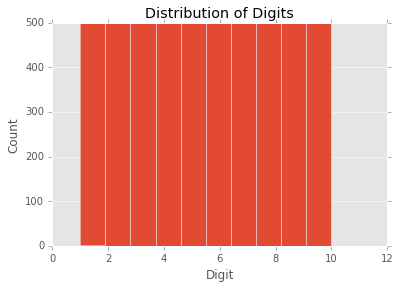

In [5]:
plt.style.use('ggplot')
plt.hist(y)
plt.xlabel('Digit')
plt.ylabel('Count')
plt.title('Distribution of Digits')

It seems the digits are balanced. There are 10 digits(1-10) in total, each should be treated as a class. And we can display the input data as well. According to the instruction, '10' is mapped into '0'.

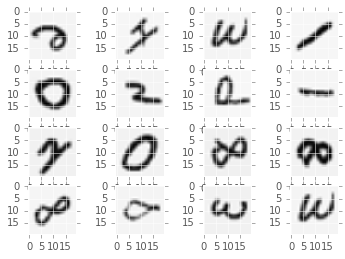

In [6]:
#Transform the original 1D data into 2D data 
def imageTransform(x):
    m = len(x)
    display_rows = int(np.sqrt(m))
    display_cols = int(m / display_rows)
    image = np.zeros([display_rows, display_cols])
    for i in range(display_rows):
        start = display_cols * i
        end = display_cols * (i + 1)
        image[i, :] = x[start:end]
    return image
#Display the input data as images
index = np.random.choice(len(X), 16)
for i in range(len(index)):
    plt.subplot(4, 4, i+1)
    image = imageTransform(X[index[i]])
    plt.imshow(image, cmap=plt.cm.gray_r)

Those are handwritten digits with certain distortions, rotations. In order to dao training and testing, we need to split the original data set into two parts.

In [7]:
#Shuffle the data and split at random
y[y==10] = 0#Map 10 into 0
np.random.seed(111)
index_shuffle = np.random.permutation(len(y))
training_num = int(len(y) * 0.8)
X_train = X[index_shuffle[:training_num]]
y_train = y[index_shuffle[:training_num]]
X_test = X[index_shuffle[training_num:]]
y_test = y[index_shuffle[training_num:]]

## Logistic Regression

In [8]:
#Define sigmoid function
def sigmoid(Z):
    return 1/(1 + np.exp(-Z))

In [9]:
#Add oncstants to the original input
#Create theta with theta0
def addOnes(X):
    if X is None:
        print 'Input Null!'
        return None, None
    dim = X.shape
    #If X has multi variables
    if dim>1:
        feature_num = X.shape[1]
        X = np.insert(X, feature_num, 1, axis=1)
        theta = np.zeros(feature_num+1)
        return X, theta
    #If X only has one variable
    else:
        temp_X = np.ones([len(X), 2])
        temp_X[:, 0] = X
        theta = np.zeros(2)
        return temp_X, theta

In [10]:
#Define cost function, X stands for input matrix
#y stands for the labels
#lambda1 stands for the regularization coefficient
def costFuncWithReg(X, y, theta, lambda1=0.01):
    '''Calculate the errors of logistic regression'''
    ###############Deal with unusual inputs###########
    if X is None or y is None:
        print 'Empty Input For Cost!'
        return None
    if len(X.shape) == 1 and len(theta) !=1 :
        print 'The input dimensions do not match!'
        return None
    if len(X) != len(y) or X.shape[1] != len(theta):
        print 'The theta dimensions do not match!'
        return None
    ##############Calculate Output####################
    sample_num = len(y)#Length of y
    feature_num = len(theta)
    H = np.dot(X, theta)#Product of X and theta
    #print H
    Z = sigmoid(H)# Sigmoid Output
    #print Z
    ##############Calculate the Cost##################
    #Split the data into two parts, y=1, y=0
    y_1 = y[y==1]
    y_0 = y[y==0]    
    Z_1 = Z[y==1]
    Z_0 = Z[y==0]
    total = -np.dot(y_1, np.log(Z_1)) - np.dot(1-y_0, np.log(1-Z_0))
    if sample_num>0:
        total = total/sample_num
    else:
        print 'Invalid Input!'
        return None
    #############Add regularization###################
    #Note, theta0 is not considered
    total += lambda1 * sum(np.square(theta[:feature_num]))/2/sample_num
    return total     

In [36]:
#Update theta values
def trainLogisticRegressionWithReg(X, y, alpha=0.01, lambda1=0.01, num_iters=30):
    '''Update theta values'''
    #Deal with extreme cases
    if X is None or y is None:
        return None
    if len(X) != len(y):
        print 'The dimensions do not match!'
        return None 
    
    #Define some variables
    [X_new, theta] = addOnes(X)#Add ones to X
    sample_num = len(y)#the length of the samples
    feature_num = len(theta)#the number of features
    cost_iter = np.zeros(num_iters)#Record the cost each time
    grad=None
    #Iteration
    for i in range(num_iters):
        #Update theta during each iteration
        diff = sigmoid(np.dot(X_new, theta)) - y
        grad = np.dot(diff, X_new)/sample_num
        print len(grad)
        grad[:feature_num] += lambda1 * theta[:feature_num]/sample_num
        theta = theta - alpha * grad
        
        cost_iter[i] = costFuncWithReg(X_new, y, theta, lambda1)
    
    return theta, cost_iter

In [37]:
X_train.shape
len(X_train)
#len(y_train)

4000

In [38]:
digit_num = 10
sample_num = len(y)
feature_num = X.shape[1]
Thetas = np.zeros([digit_num, feature_num+1])

In [39]:
for i in range(1):
    y_digit = y_train== i
    y_digit = y_digit * 1
    grad = trainLogisticRegressionWithReg(X=X_train, y=y_digit, alpha=0.001, lambda1=0.01, num_iters=1)
    len(grad)
    #plt.subplot(5, 2, i+1)
    #plt.plot(costs)

4000
The theta dimensions do not match!


In [28]:
#theta = np.ones(401)/5
temp, theta = addOnes(X_train)
diff = sigmoid(np.dot(temp, theta))
len(diff)

4000

In [29]:
temp.shape
grad=np.dot(diff, temp)

In [30]:
len(grad)

401

In [202]:
len(error)

4000

In [199]:
temp.shape

(4000L, 401L)

In [172]:
a=np.array(range(1100))
b=np.ones([1100,400])
len(np.dot(a,b))

400

In [173]:
error

array([[-0.5, -0.5, -0.5, ..., -0.5, -0.5, -0.5],
       [-6.5, -6.5, -6.5, ..., -6.5, -6.5, -6.5],
       [-7.5, -7.5, -7.5, ..., -7.5, -7.5, -7.5],
       ..., 
       [-2.5, -2.5, -2.5, ..., -2.5, -2.5, -2.5],
       [-6.5, -6.5, -6.5, ..., -6.5, -6.5, -6.5],
       [-8.5, -8.5, -8.5, ..., -8.5, -8.5, -8.5]])

In [174]:
temp

array([[ 0.,  0.,  0., ...,  0.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.]])

In [155]:
help(np.dot)

Help on built-in function dot in module numpy.core.multiarray:

dot(...)
    dot(a, b, out=None)
    
    Dot product of two arrays.
    
    For 2-D arrays it is equivalent to matrix multiplication, and for 1-D
    arrays to inner product of vectors (without complex conjugation). For
    N dimensions it is a sum product over the last axis of `a` and
    the second-to-last of `b`::
    
        dot(a, b)[i,j,k,m] = sum(a[i,j,:] * b[k,:,m])
    
    Parameters
    ----------
    a : array_like
        First argument.
    b : array_like
        Second argument.
    out : ndarray, optional
        Output argument. This must have the exact kind that would be returned
        if it was not used. In particular, it must have the right type, must be
        C-contiguous, and its dtype must be the dtype that would be returned
        for `dot(a,b)`. This is a performance feature. Therefore, if these
        conditions are not met, an exception is raised, instead of attempting
        to be flex